<a href="https://colab.research.google.com/github/naagarjunsa/data-science-portfolio/blob/main/deep-learning/image_classification_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-03-08 16:12:57--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 66.102.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   158MB/s    in 0.4s    

2021-03-08 16:12:57 (158 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [20]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [6]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.256.jpg', 'cat.762.jpg', 'cat.781.jpg', 'cat.998.jpg', 'cat.381.jpg', 'cat.2.jpg', 'cat.113.jpg', 'cat.443.jpg', 'cat.516.jpg', 'cat.625.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

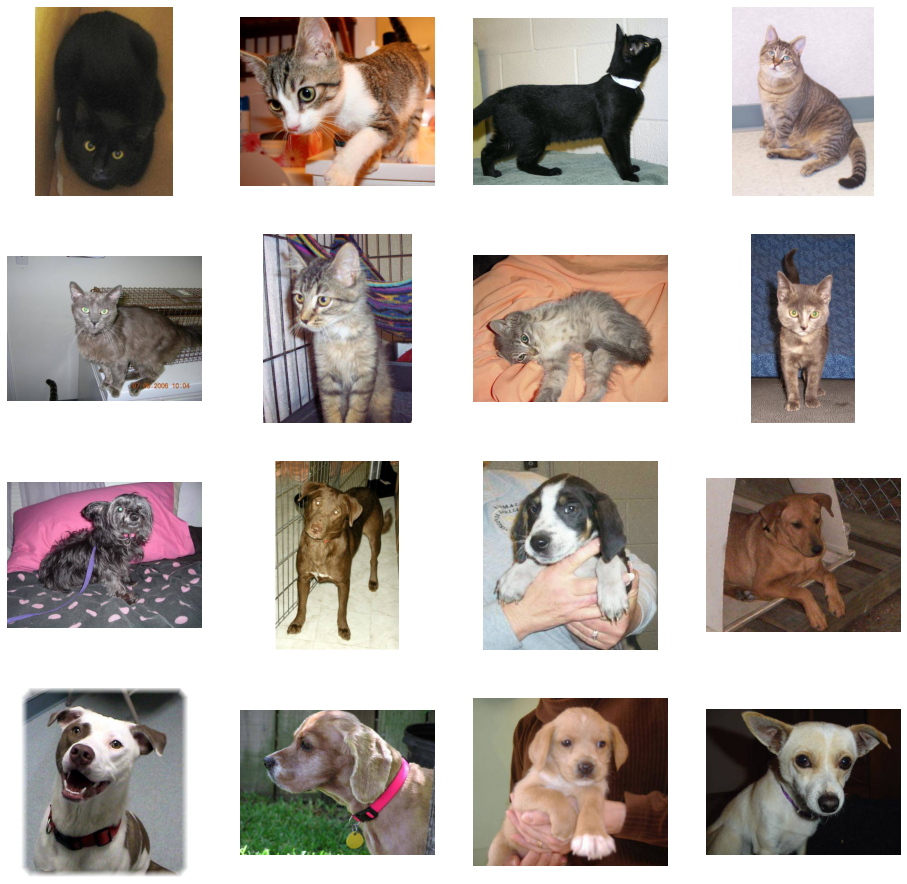

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [13]:
from keras import layers
from keras import models
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator

import numpy as np

In [11]:
conv_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(150,150,3)
)

58892288/58889256 [==============================] - 1s 0us/step


In [19]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary'
  )
  i=0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, 
                    train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 7ms/step - loss: 1.4782 - acc: 0.6730 - val_loss: 0.3027 - val_acc: 0.8580
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3319 - acc: 0.8483 - val_loss: 0.3265 - val_acc: 0.8510
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2822 - acc: 0.8803 - val_loss: 0.3111 - val_acc: 0.8830
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2660 - acc: 0.8997 - val_loss: 0.3703 - val_acc: 0.8720
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2464 - acc: 0.9052 - val_loss: 0.2880 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.1880 - acc: 0.9325 - val_loss: 0.2957 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.1536 - acc: 0.9381 - val_loss: 0.4199 - val_acc: 0.8740
Epoch 8/30
100/100 [==============================] - 1s 6ms/step - loss: 0.

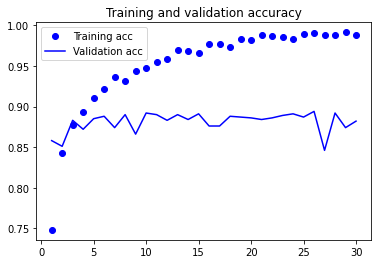

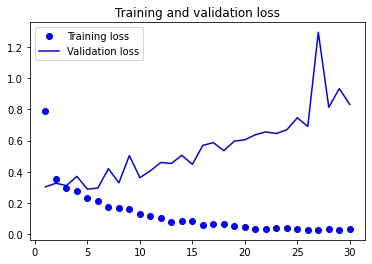

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [29]:
conv_base.trainable = False
len(model.trainable_weights)

4

In [31]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 27s 261ms/step - loss: 1.2417 - acc: 0.6307 - val_loss: 0.3734 - val_acc: 0.8250
Epoch 2/30
100/100 [==============================] - 26s 260ms/step - loss: 0.4966 - acc: 0.7654 - val_loss: 0.3038 - val_acc: 0.8620
Epoch 3/30
100/100 [==============================] - 26s 258ms/step - loss: 0.4272 - acc: 0.7981 - val_loss: 0.3632 - val_acc: 0.8560
Epoch 4/30
100/100 [==============================] - 26s 261ms/step - loss: 0.4034 - acc: 0.8180 - val_loss: 0.2714 - val_acc: 0.8800
Epoch 5/30
100/100 [==============================] - 26s 260ms/step - loss: 0.3656 - acc: 0.8454 - val_loss: 0.3102 - val_acc: 0.8770
Epoch 6/30
100/100 [==============================] - 26s 258ms/step - loss: 0.3407 - acc: 0.8417 - val_loss: 0.3051 - val_acc: 0.8660
Epoch 7/30
100/100 [==============================] - 26s 257ms/step - loss: 0.3556 - acc: 0.8445 - val_loss: 0.2738 - val_acc: 0.8890
Epoch 8/30
100/100 [==============================] - 2

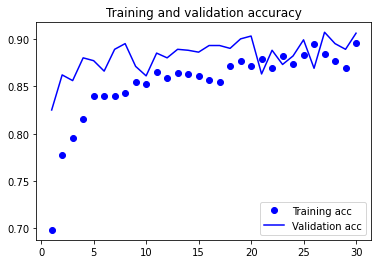

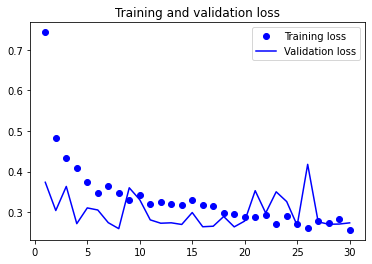

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()